In [1]:
import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dists

import matplotlib; # matplotlib.use('Agg')  # Allows to create charts with undefined $DISPLAY
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

from model import FullyConnected, BayesianRegression
from viz import *
from util import *

### 100 datapoints with 15-20 bases. Look at prior distribution

In [2]:
# define model
w_prior_var = 1.0 # variance of prior over weights
output_var = 0.01 # variance of observation noise
model = BayesianRegression(w_prior_var, output_var)

# parameters of optimizer
LEARNING_RATE = 0.001 
EPOCHS = 5000

# architecture and activation
ACTIVATION = nn.ReLU
num_final_layers = 15 # number of basis functions 
layers = [1, 50, num_final_layers, 1]

# define a neural network feature basis and final layer
basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)


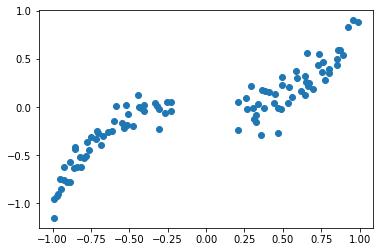

In [3]:
# set training data
%matplotlib inline
N = 100
# x_train = dists.Uniform(-1.0, -0.5).sample((N/2, 1))
x_train = torch.cat((dists.Uniform(-1.0, -0.2).sample((N//2, 1)), dists.Uniform(0.2, 1).sample((N//2, 1))))
y_train = add_output_noise(torch.pow(x_train, 3.0), output_var)
plt.scatter(x_train,y_train)

In [4]:

# define MLE loss
def mle_loss():
    y_pred = final_layer(basis(x_train))
    loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))
    
    return loss, (basis, final_layer)
 
# define MAP loss
def map_loss(k):
    y_pred = final_layer(basis(x_train))
    loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1)) + k*(torch.linalg.norm(torch.cat((basis.get_weights(),final_layer.get_weights())), 2))**2
    
    return loss, (basis, final_layer)


In [ ]:
# randomly initialize basis and last layer
basis.rand_init(math.sqrt(w_prior_var))
final_layer.rand_init(math.sqrt(w_prior_var))
    

### Visualization for training with MLE

In [5]:
# randomly initialize basis and last layer
basis.rand_init(math.sqrt(w_prior_var))
final_layer.rand_init(math.sqrt(w_prior_var))

# optimize loss to learn network
(basis, final_layer), loss = train_objective(
    list(basis.parameters()) + list(final_layer.parameters()),
    loss_fn_name = "mle_loss",
    loss_fn = mle_loss,
    lr=LEARNING_RATE,
    print_freq=1000,
    epochs = EPOCHS,
    k=0
)

Epoch 0: loss = 30.704822164516546
Epoch 1000: loss = 0.016972735741518245
Epoch 2000: loss = 0.013863422606854883
Epoch 3000: loss = 0.013335303556064848
Epoch 4000: loss = 0.012899170650448375
Final Loss = 0.012519136466116944


In [6]:
# infer posterior over the last layer weights given the basis
posterior, posterior_mean = model.infer_posterior(basis(x_train), y_train)

In [6]:
def plot_1d_prior_predictive(x_train, y_train, x_viz, y_pred, title = ""):
    assert(len(x_train.shape) == 2 and x_train.shape[-1] == 1)
    assert(len(y_train.shape) == 2 and y_train.shape[-1] == 1)
    assert(len(x_viz.shape) == 2 and x_viz.shape[-1] == 1)    
    assert(len(y_pred.shape) == 2 and y_pred.shape[0] == x_viz.shape[0])

    # make sure x_viz is sorted in ascending order
    x_viz = to_np(x_viz.squeeze())
    assert(np.all(x_viz[:-1] <= x_viz[1:]))
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # plot predictive intervals
    for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
        lower, upper = get_coverage_bounds(to_np(y_pred), picp)
        
        ax.fill_between(
            x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
        )

    # plot predictive mean
    pred_mean = to_np(torch.mean(y_pred, -1))        
    ax.plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')

    # plot training data
    ax.scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')
    ax.set_ylim(-30,30)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')    
    ax.set_title('Prior Predictive' +  title)
    ax.legend()
    

    plt.show()


In [7]:
def sample_prior_predictive(self, x, num_samples, output_noise=True):
    phi = self.data_to_features(x)

    weights = dists.Normal(0.0, math.sqrt(self.weights_var)).sample((num_samples, phi.shape[-1]))
    assert(len(weights.shape) == 2)

    r = torch.mm(phi, weights.t())
    assert(r.shape == torch.Size([x.shape[0], num_samples]))

    if output_noise:
        return add_output_noise(r, self.output_var)    
    return r


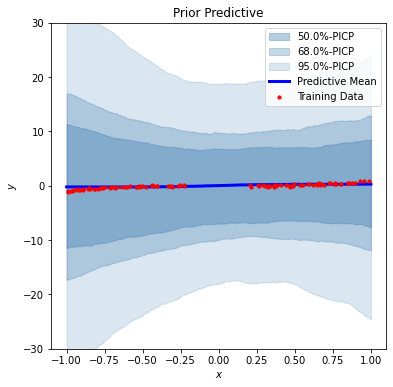

In [11]:
# sample from prior 
x_viz = ftens_cuda(np.linspace(-1, 1, 500)).unsqueeze(-1)
y_pred_prior = model.sample_prior_predictive(basis(x_viz), 500) #basis(x_viz) are the basis functions

# visualize prior predictive
%matplotlib inline
plot_1d_prior_predictive(x_train, y_train, x_viz, y_pred_prior)


In [10]:
# TODO: add visualization of bases here
basis_vals = plot_basis_functions_1d(num_final_layers, x_viz, basis, x_train, posterior_mean, numcols=12)

NameError: name 'posterior_mean' is not defined

In [12]:
basis_fns = basis(x_viz)
basis_edited = basis(x_viz)

### Plot basis functions

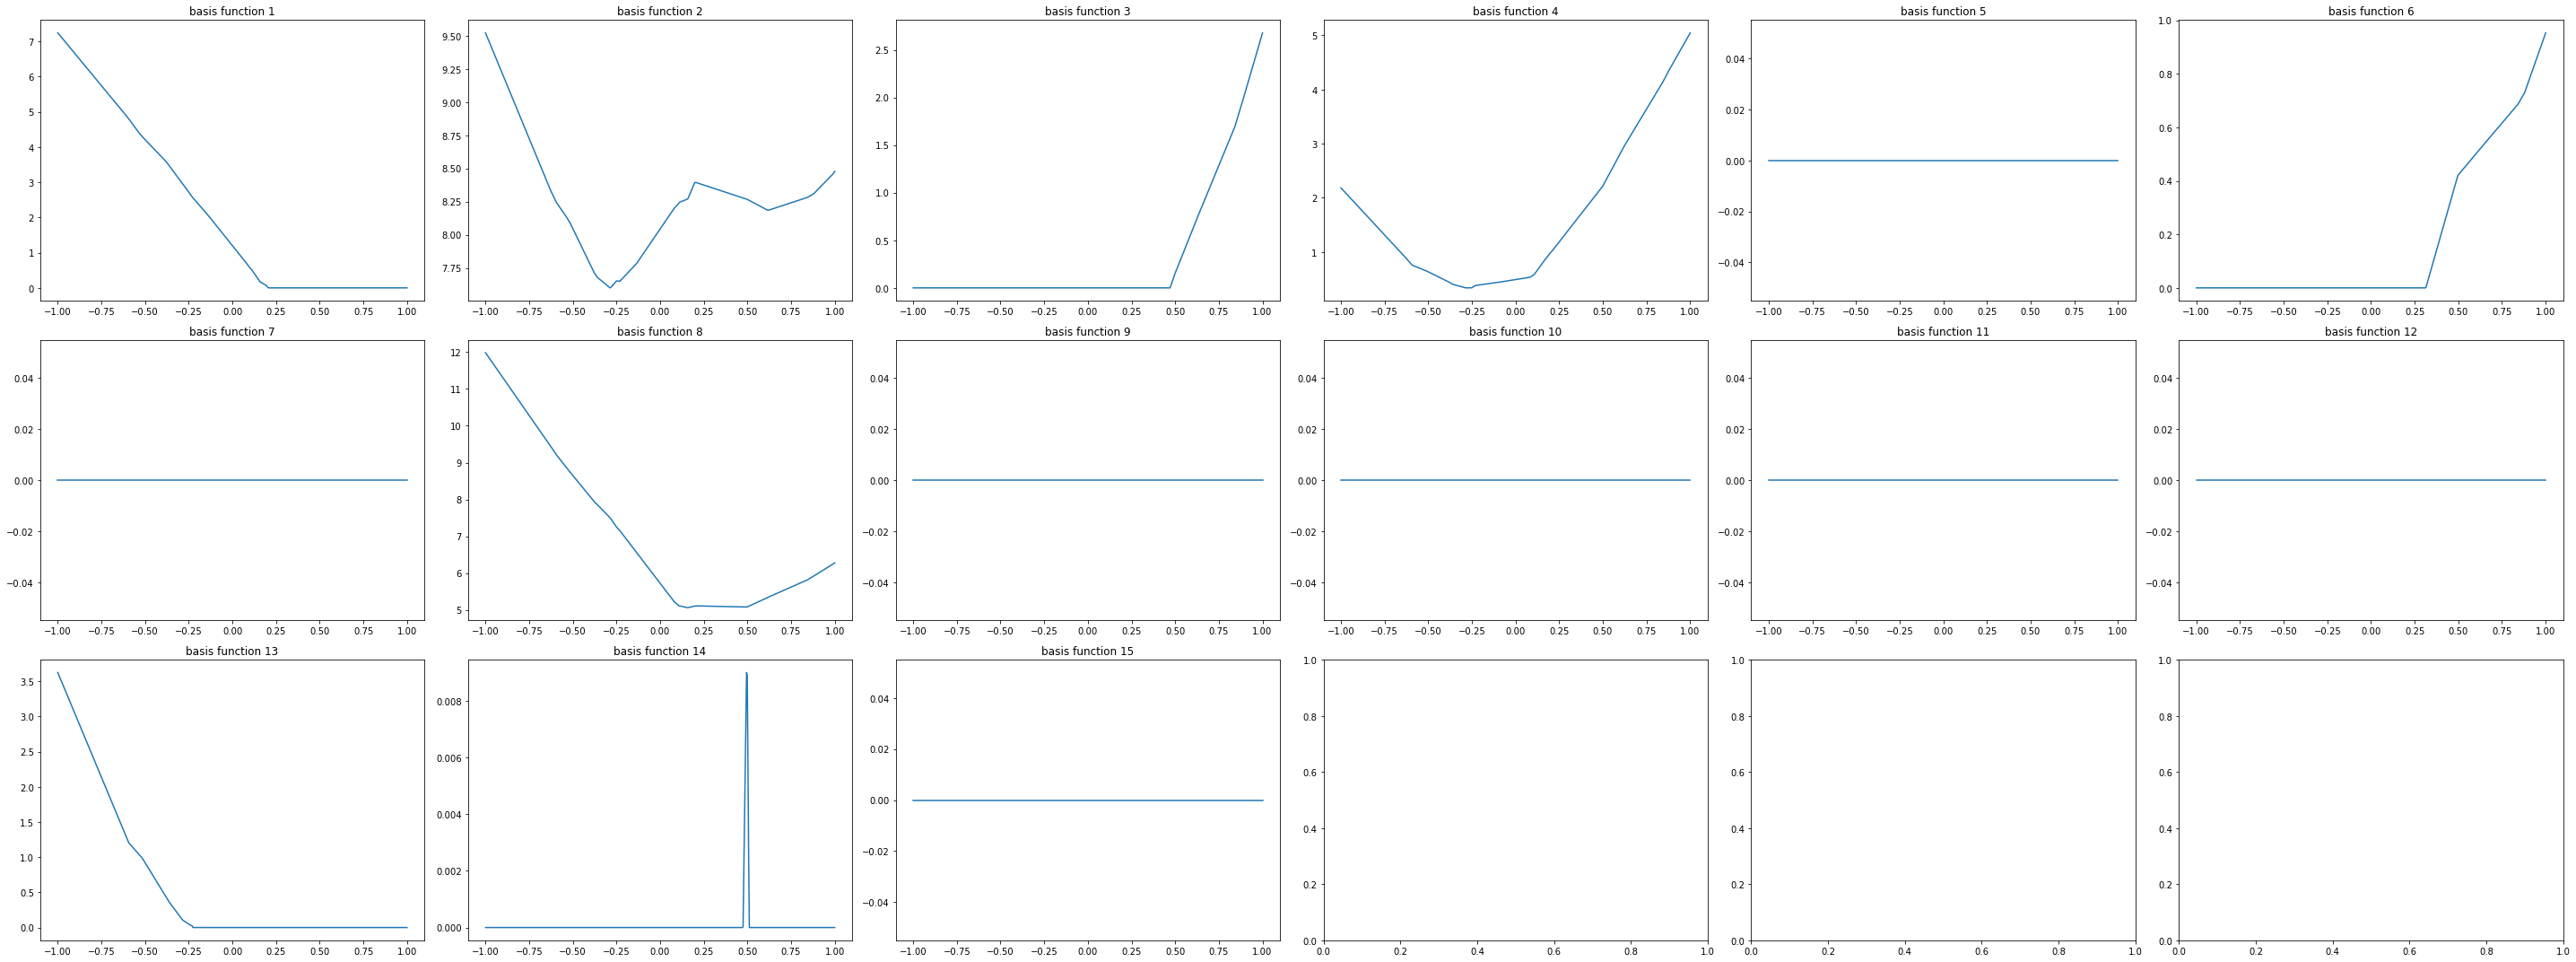

In [18]:
%matplotlib inline
# plot basis functions
numcols = 6
fig, axs = plt.subplots(num_final_layers//numcols + 1, numcols, figsize=(40, 15))
for j in range(num_final_layers):
    row, col = j//numcols, j % numcols
    axs[row,col].plot(x_viz.detach().numpy(), basis_fns[:,j].reshape((500,1)).detach().numpy())
    #axs[row,col].scatter(x_train_np, basis_train_np[:,i], c="red") # scatterplot training data
    axs[row,col].set_title(f"basis function {j+1}")
plt.tight_layout()
plt.show()

### Plot prior predictive, setting all bases to 0 one by one

1  bases set to 0


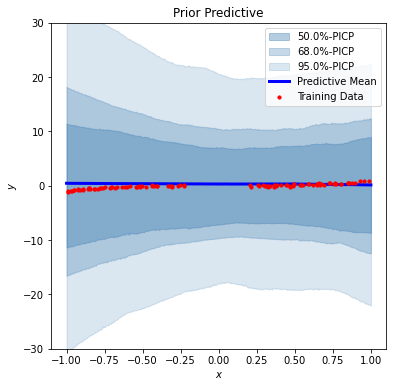

2  bases set to 0


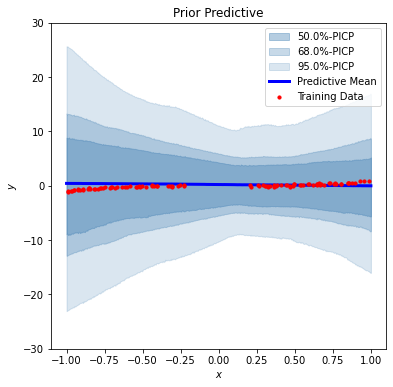

3  bases set to 0


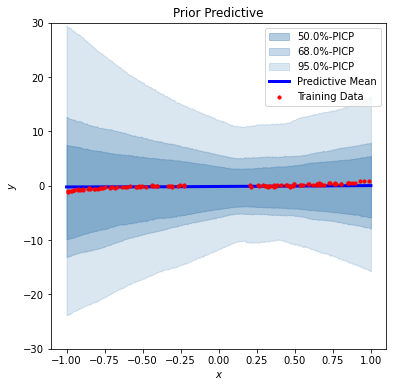

4  bases set to 0


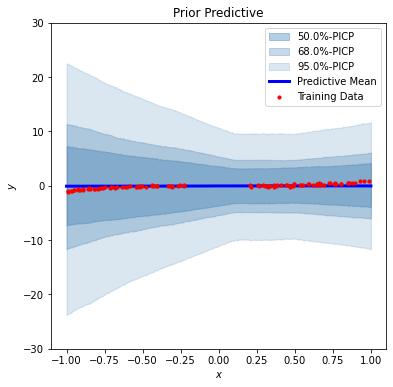

5  bases set to 0


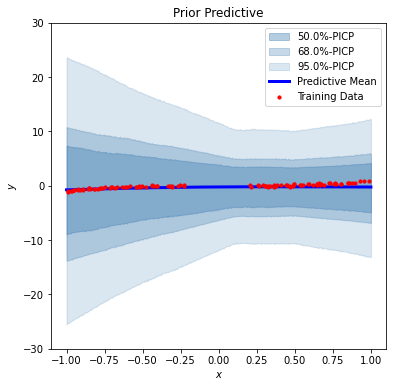

6  bases set to 0


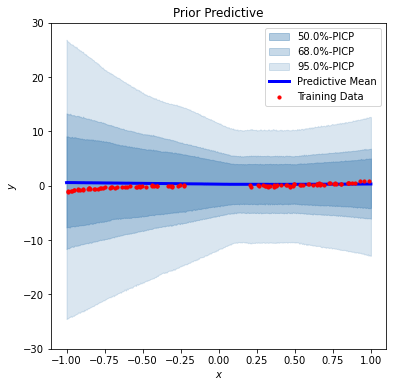

7  bases set to 0


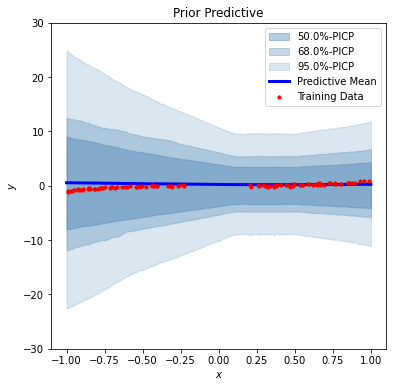

8  bases set to 0


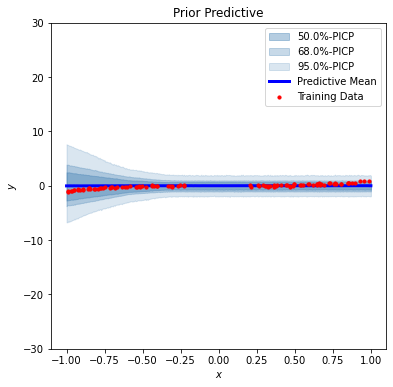

9  bases set to 0


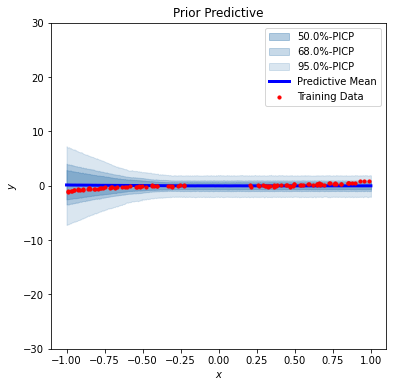

10  bases set to 0


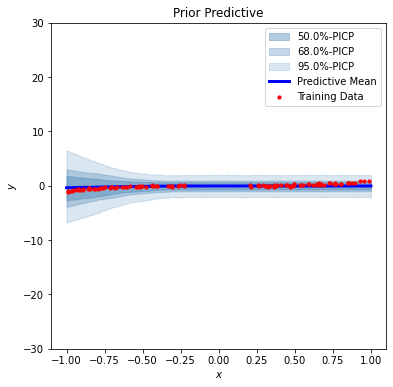

11  bases set to 0


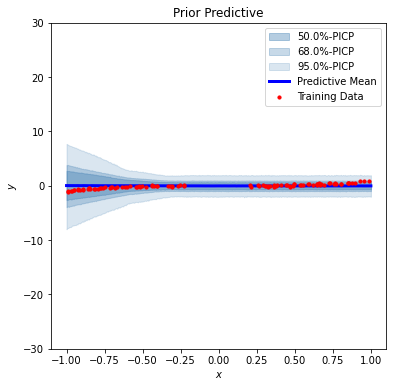

12  bases set to 0


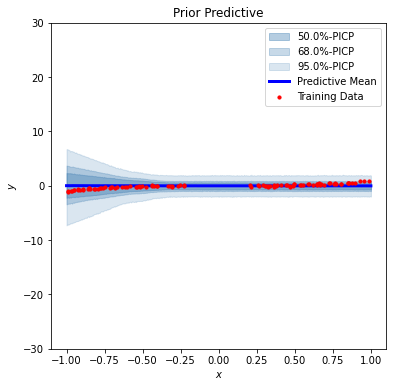

13  bases set to 0


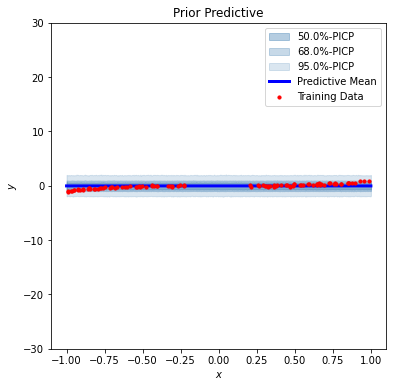

14  bases set to 0


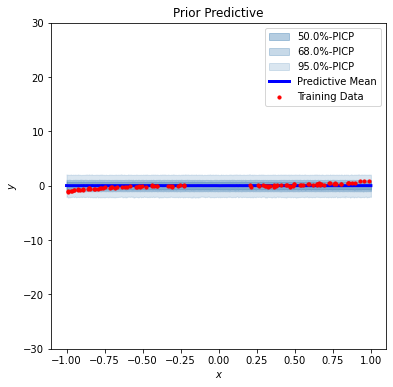

15  bases set to 0


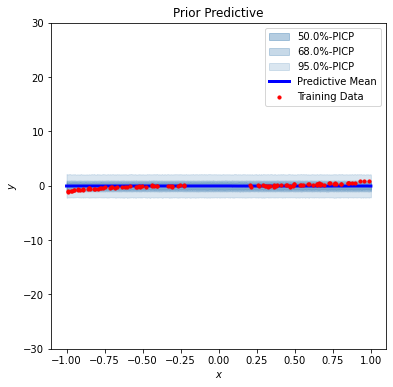

In [17]:
%matplotlib inline
# set all bases to 0 one by one
basis_edited = basis(x_viz)

for i in range(basis_edited.shape[1]):
    basis_edited[:, i] = 0
    y_pred_prior = model.sample_prior_predictive(basis_edited, 500) 
    #basis_edited are the edited basis functions (each time setting one of them to 0)
    
    print(i+1, " bases set to 0")
    # visualize prior predictive
    plot_1d_prior_predictive(x_train, y_train, x_viz, y_pred_prior)
    
     

### Plot prior predictive, choose one basis and set it to 0

the  1 th basis set to 0


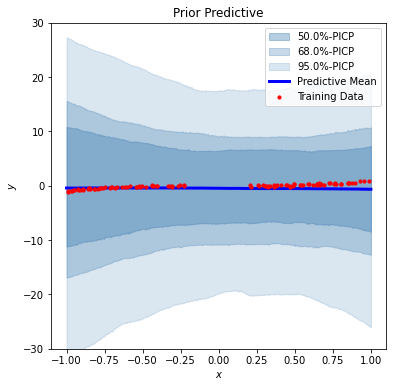

the  2 th basis set to 0


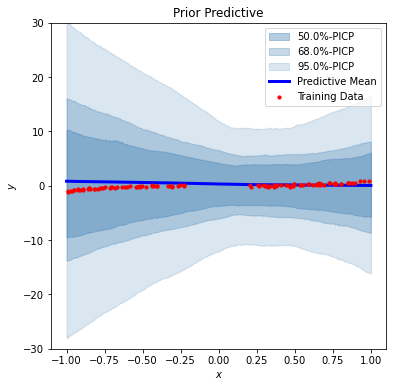

the  3 th basis set to 0


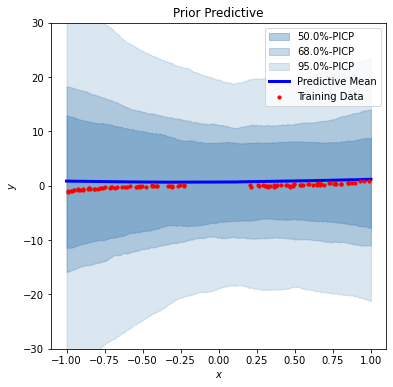

the  4 th basis set to 0


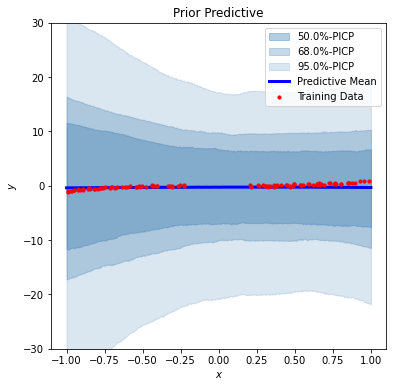

the  5 th basis set to 0


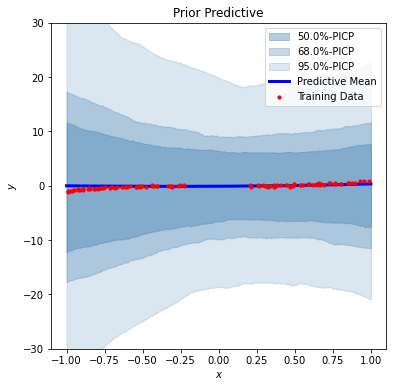

the  6 th basis set to 0


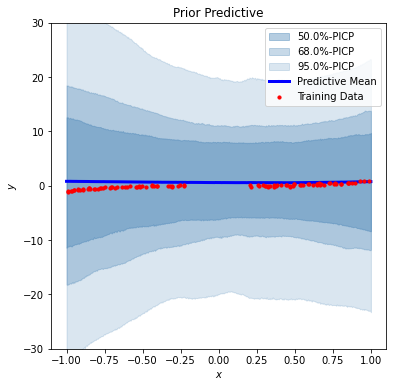

the  7 th basis set to 0


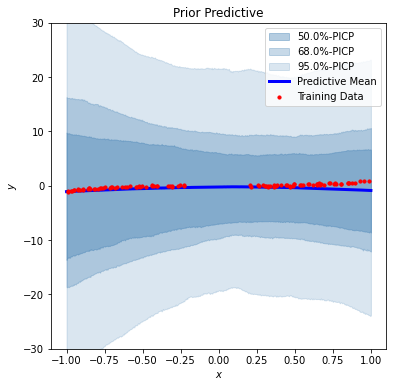

the  8 th basis set to 0


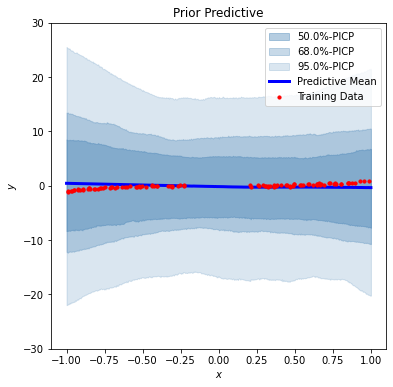

the  9 th basis set to 0


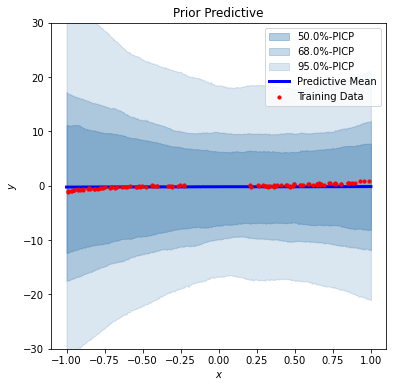

the  10 th basis set to 0


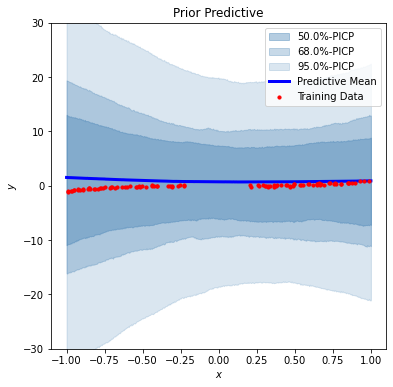

the  11 th basis set to 0


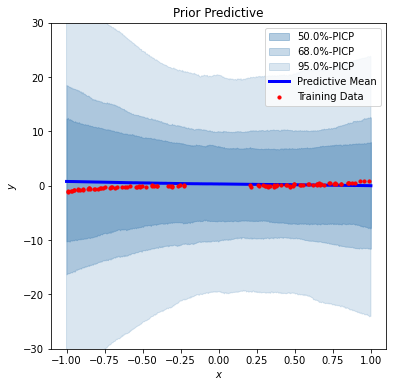

the  12 th basis set to 0


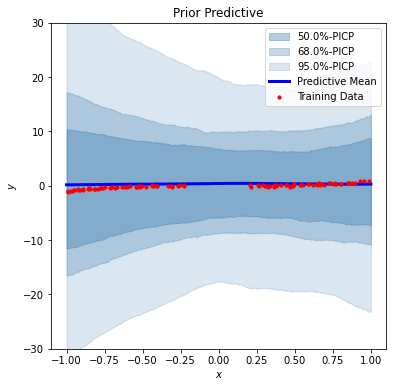

the  13 th basis set to 0


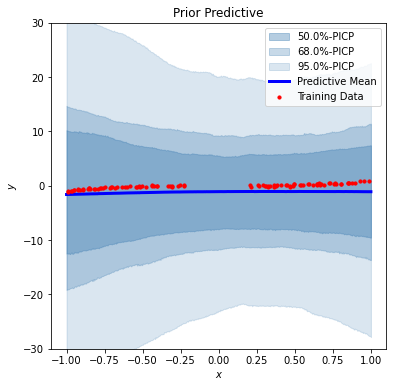

the  14 th basis set to 0


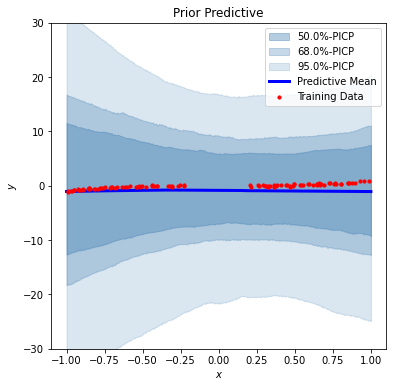

the  15 th basis set to 0


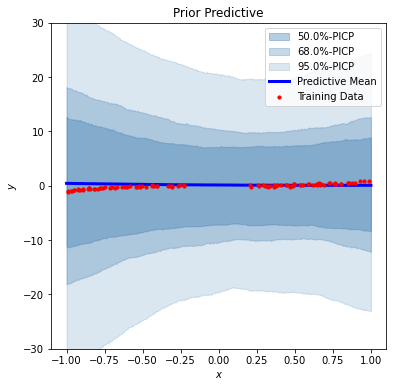

In [24]:
# set one basis to 0 one by one
for i in range(basis_fns.shape[1]):
    basis_tmp = basis(x_viz)
    basis_tmp[:, i] = 0
    y_pred_prior = model.sample_prior_predictive(basis_tmp, 500) 
    print("the ",i+1, "th basis set to 0")
    
    # visualize prior predictive
    plot_1d_prior_predictive(x_train, y_train, x_viz, y_pred_prior)
    


the second and the eighth bases seem to contribute more to the prior uncertainty. Maybe smoothness does say something. 